# 프로젝트 : Segmentation map으로 도로 이미지 만들기

---
## 데이터 준비
---

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


#### 학습용 데이터셋에서 임의로 6장을 선택하여 시각화

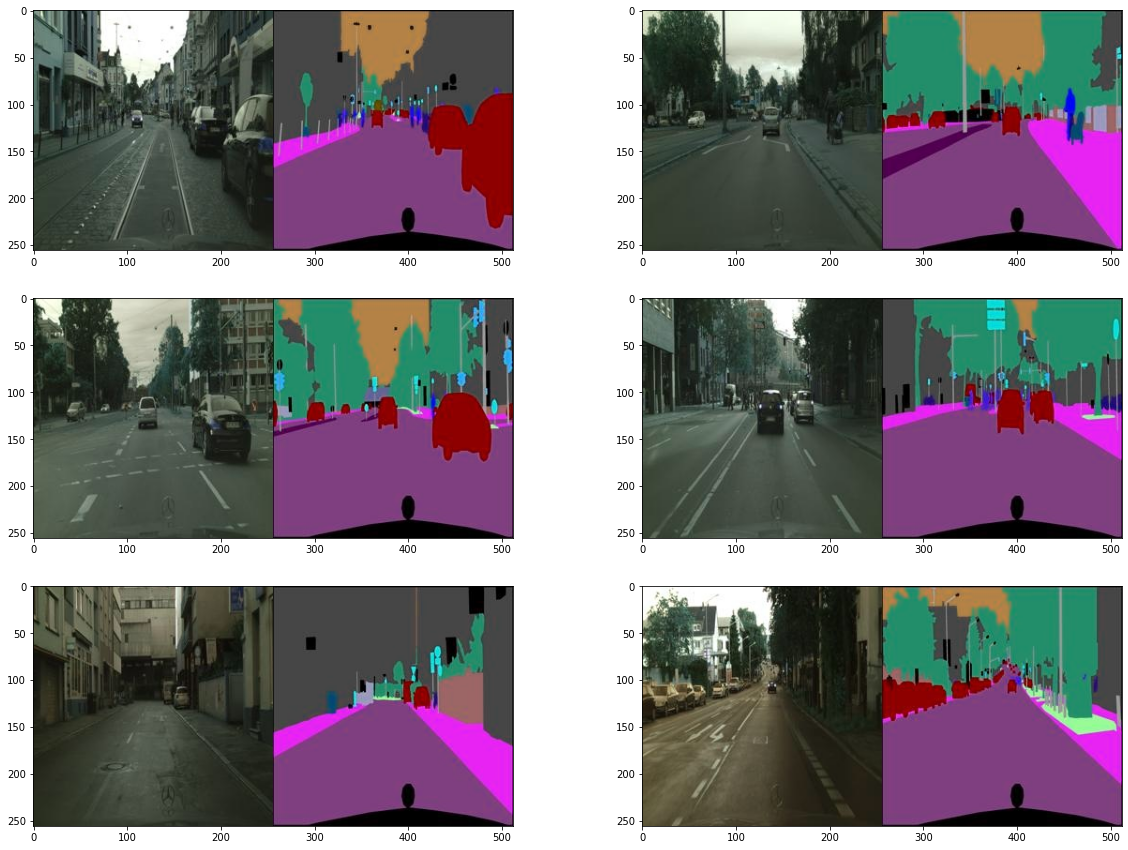

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
# 이미지 shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


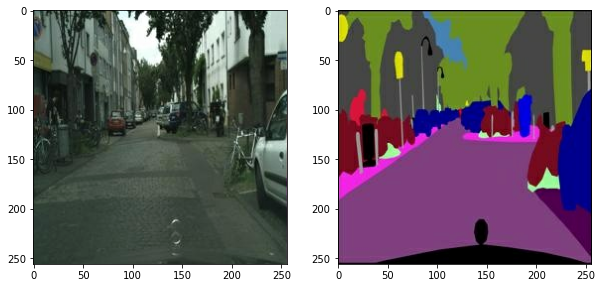

In [6]:
#----------------------------------------------------------------------------
# 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하는 함수
#----------------------------------------------------------------------------
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)
#----------------------------------------------------------------------------

# 테스트
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

#### Augmentation
기존 데이터를 변형, 확장 혹은 재구성하여 데이터셋의 크기를 증가시키는 기법  
- 모델의 일반화 능력을 향상, 과대적합 방지, 데이터의 불균형 문제 해소를 위해 사용
- 상하 혹은 좌우로 뒤집기, 회전, 크롭(Cropping), 확대 및 축소 등의 기법 사용

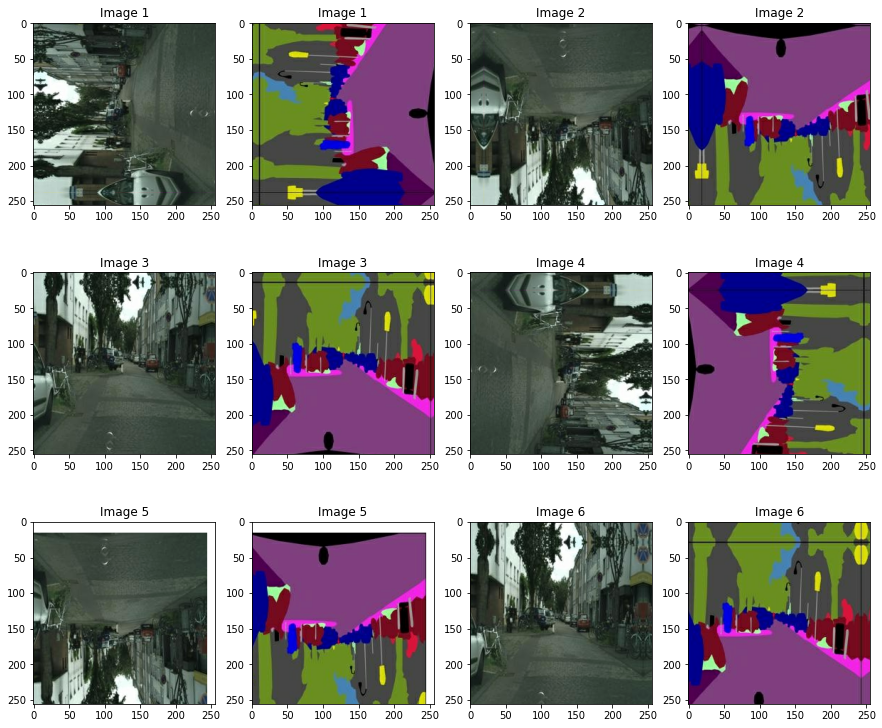

In [7]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

#----------------------------------------------------------------------------------------
# 스케치 및 채색된 2개 이미지를 입력으로 받아 랜덤 연산을 두 이미지에 동일하게 적용
#----------------------------------------------------------------------------------------
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    # 역방향 축으로 이미지(텐서) 결합
    stacked = tf.concat([sketch, colored], axis=-1)
    
    # 랜덤으로 REFLECT 또는 CONSTANT 모드를 지정하여 30픽셀 만큼 패딩
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 256*256*6 크기로 랜덤으로 자르기
    out = image.random_crop(padded, size=[256, 256, 6])
    # 무작위로 좌우 반전
    out = image.random_flip_left_right(out)
    # 무작위로 상하 반전
    out = image.random_flip_up_down(out)
    # 무작위 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   
#----------------------------------------------------------------------------------------

#  테스트
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

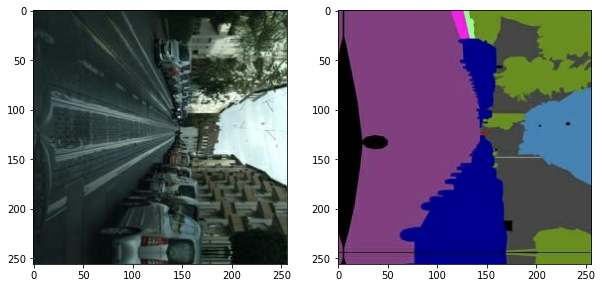

In [8]:
# 학습 데이터에 위 랜덤 변환 함수 적용
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

# 하나의 이미지 시각화 확인
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

---
## Generator 구성하기
---
### Generator의 구성요소
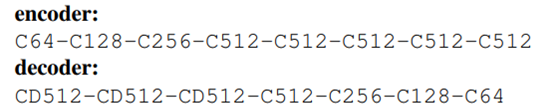  
**C64** : 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU  
**CD512** : 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU  
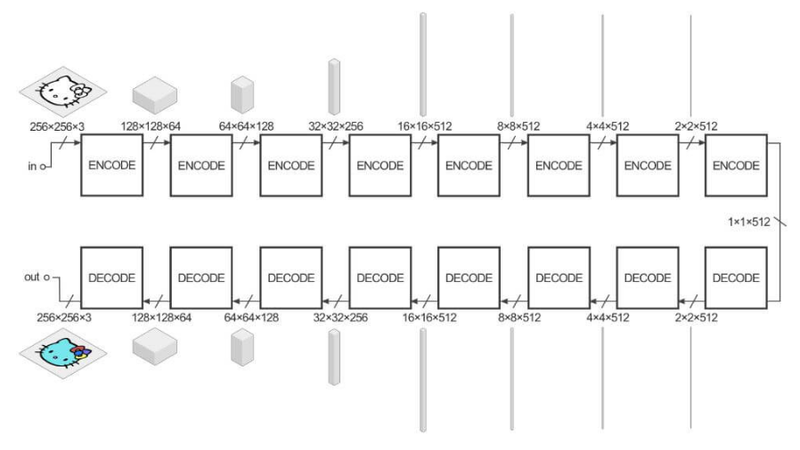  

### Generator : U-Net Generator

In [10]:
from tensorflow.keras import layers, Input, Model
#--------------------------------------------------------------------------
# 인코드 블럭 클래스
#--------------------------------------------------------------------------
'''
3개 레이어로 구성된 기본 블록
Convolution → BatchNorm → LeakyReLU 

생성자 Parameters
- n_filters : Convolution 필터 수
- use_bn : BatchNorm 적용 여부 (default: True)
'''

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False) #필터의 크기(=4) 및 stride(=2) 고정
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2) #slope coefficient(=0.2) 고정

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
#--------------------------------------------------------------------------
# 디코드 블럭 클래스
#--------------------------------------------------------------------------
'''
4개 레이어로 구성된 기본 블록
(Transposed) Convolution → BatchNorm → 50% Dropout → ReLU 

생성자 Parameters
- f : TransposeConvolution 필터 수
- dropout : Dropout 적용 여부 (default: True)
'''
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False) #필터의 크기(=4) 및 stride(=2) 고정
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x) #(.5) 50% Dropout
        return self.relu(x)
#--------------------------------------------------------------------------
# U-Net Generator 클래스
#--------------------------------------------------------------------------
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        
        # 인코딩 레이어
        encode_filters = [64,128,256,512,512,512,512,512]        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            self.encode_blocks.append(EncodeBlock(f, i != 0))
            
        # 디코딩 레이어
        decode_filters = [512,512,512,512,256,128,64]
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            self.decode_blocks.append(DecodeBlock(f, i < 3))        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            # Encoder와 Decoder 사이의 skip connection을 위해 Encoder 내에서 사용된 각 블록들의 출력 저장
            features.append(x)             
        
        # 마지막 Encoder 출력 삭제
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            # Encoder와 Decoder skip connection
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
#--------------------------------------------------------------------------
UNetGenerator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_2[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

---
## Discriminator 구성하기
---
### Discriminator의 구성요소
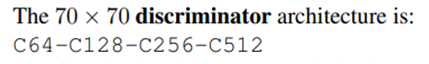  
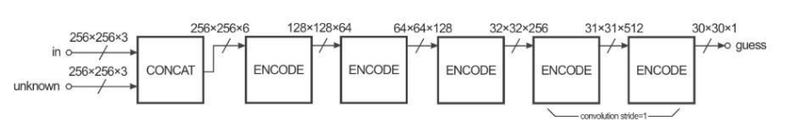  
- 2개 입력(위 그림의 "in", "unknown")을 받아 연결(**CONCAT**)한 후, ENCODE 라고 쓰인 5개의 블록을 통과
- 마지막 블록을 제외한 4개 블록은 위에서 표기된 **C64-C128-C256-C512** 에 해당
- 최종적으로 출력되는 크기는 (30,30,1) : **70x70 PatchGAN** 사용

 
출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소

Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소

1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 
그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같네요.🤔 

이 부분이 지금 이해되지 않는다면 아래 코드에서 다시 다룰 테니 우선 넘어갑시다.


최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.

Convolution Layer에서 kernel크기, stride, padding 등을 토대로 출력 크기를 계산했던 방식을 그대로 사용하면 계산할 수 있는데요. 
자세한 계산 과정은 아래 링크를 참고하세요.

#### Discriminator 구현

In [11]:
#--------------------------------------------------------------------------
# Discriminator 기본 블럭 클래스
#--------------------------------------------------------------------------
'''
4개 레이어로 구성된 기본 블록
(Transposed) Convolution → BatchNorm → 50% Dropout → ReLU 

생성자 Parameters
- n_filters : Convolution 필터 수
- stride : Convolution stride
- custom_pad : ZeroPadding2D 적용 여부 (default: False 자동 패딩)
- use_bn : BatchNorm 적용 여부 (default: True)
- act : LeakyReLU 적용 여부 (default: True)
'''
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 
#--------------------------------------------------------------------------
# Discriminator 클래스
#--------------------------------------------------------------------------
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.concat = layers.Concatenate()
        self.blocks = []
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            is_first = i == 0
            is_last = i == (len(filters) - 1)
            stride = 2 if i<3 else 1
            custom_pad = False if i<3 else True
            use_bn = False if (is_first or is_last) else True
            act = not is_last
            self.blocks.append(DiscBlock(f, stride, custom_pad, use_bn, act))
        self.sigmoid = layers.Activation('sigmoid')
        
    def call(self, x, y):
        out = self.concat([x, y])
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
#--------------------------------------------------------------------------
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_14[0][0]       

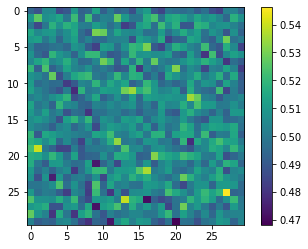

In [12]:
# 임의의 256,256,3 입력시 30,30 출력 테스트
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

---
## 학습 및 테스트
---
### 학습에 필요한 손실 함수 정의

#### Generator 및 Discriminator 손실 함수

In [13]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

#-----------------------------------------------------------------
# Generator 손실함수
#-----------------------------------------------------------------
''' 
Parameters
- fake_output : 가짜 이미지
- real_output : 실제 이미지
- fake_disc : Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻은 값

Return
- gene_loss : BinaryCrossentropy 
- l1_loss : MeanAbsoluteError 
'''
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

#-----------------------------------------------------------------
# Discriminator 손실함수
#-----------------------------------------------------------------
'''
Parameters
- fake_disc : 가짜 이미지를 Discriminator에 입력하여 얻은 값
- real_disc : 진짜 이미지를 Discriminator에 입력하여 얻은 값

Return
- fake MeanAbsoluteError + real MeanAbsoluteError
'''
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

#-----------------------------------------------------------------


### optimizer 설정

In [14]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

### 하나의 배치 크기 데이터 입력시 가중치 1회 업데이트 함수

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator
        fake_colored = generator(sketch, training=True)

        # Discriminator
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)

        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)

        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

### 10 Epoch 학습

In [25]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (real, segments) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segments, real)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.7506                     
L1_loss:0.2177                     
Discriminator_loss:1.6021

EPOCH[1] - STEP[20]                     
Generator_loss:0.7022                     
L1_loss:0.1804                     
Discriminator_loss:1.5882

EPOCH[1] - STEP[30]                     
Generator_loss:0.6728                     
L1_loss:0.2232                     
Discriminator_loss:1.4440

EPOCH[1] - STEP[40]                     
Generator_loss:0.6598                     
L1_loss:0.1925                     
Discriminator_loss:1.3931

EPOCH[1] - STEP[50]                     
Generator_loss:0.7346                     
L1_loss:0.1750                     
Discriminator_loss:1.4338

EPOCH[1] - STEP[60]                     
Generator_loss:0.7462                     
L1_loss:0.1756                     
Discriminator_loss:1.4120

EPOCH[1] - STEP[70]                     
Generator_loss:0.6983                     
L1_loss:0.1786                    

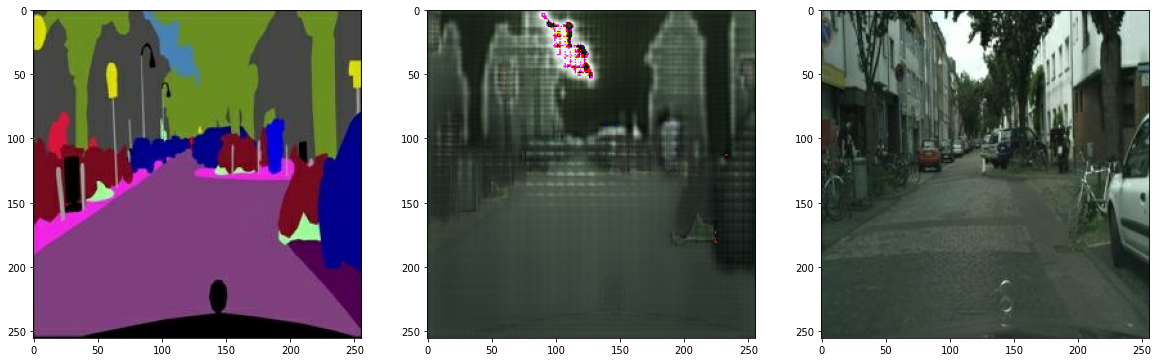

In [26]:
# 시각화 테스트
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
real, segment = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(real))